In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Image
import math
import pickle
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec

# comparing phenotypes between lists of eids

In [2]:
# load phenotype data
pheno_cat = pd.read_csv('../00_csv_files/pheno_cat.csv')
pheno_strat = pd.read_csv('../00_csv_files/pheno_strat.csv')
pheno_int = pd.read_csv('../00_csv_files/pheno_int.csv')
pheno_cont = pd.read_csv('../00_csv_files/pheno_cont.csv')
pheno_dfs = [pheno_cat, pheno_cont, pheno_int, pheno_strat]

# make dictionary: phenotypes => what file they are from (and what type they are)
pheno_type = {}
cats = pheno_cat.columns.tolist()[1:]
for c in cats:
    pheno_type[c] = 'cat'
strats = pheno_strat.columns.tolist()[1:]
for s in strats:
    pheno_type[s] = 'strat'
ints = pheno_int.columns.tolist()[1:]
for i in ints:
    pheno_type[i] = 'int'
conts = pheno_cont.columns.tolist()[1:]
for co in conts:
    pheno_type[co] = 'cont'

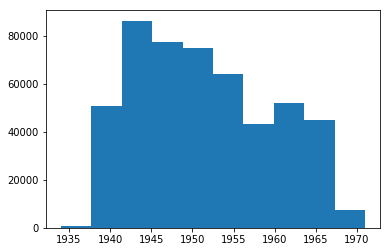

1934
1971
77
40


In [8]:
yob = pheno_int['Year of birth'].values
plt.hist(yob)
plt.show()
print(min(yob))
print(max(yob))
print(2011-min(yob))
print(2011-max(yob))

In [6]:
# functions
def get_ncolors_from_cmap(num_colors,colormap='viridis'):
    cmap = cm.get_cmap(colormap)
    cols = [cmap(x) for x in np.linspace(0,1,num_colors)]
    return cols

def get_pheno_vector(phe, pheno_type, pheno_dfs, stayers, movers, showPlot = True):
    # from a phenotype, and a list of mover / stayer eids
    # return mean_stayers, mean_movers, percDiff, n_stayers, n_movers
    
    [pheno_cat, pheno_cont, pheno_int, pheno_strat] = pheno_dfs
    
    if pheno_type[phe] == 'cat':
        df = pheno_cat
        plotType = 'stacked'
    elif pheno_type[phe] == 'cont':
        df = pheno_cont
        plotType = 'boxes'
    elif pheno_type[phe] == 'int':
        df = pheno_int
        plotType = 'boxes'
    else:
        df = pheno_strat
        plotType = 'stacked'
    
    # remove nan
    stayer_phenotypes = [x for x in df[df['eid'].isin(stayers)][phe].tolist() if x >= 0 ]
    mover_phenotypes =  [x for x in df[df['eid'].isin(movers) ][phe].tolist() if x >= 0 ]
    
    n_stayers = len(stayer_phenotypes)
    n_movers =  len(mover_phenotypes)
    
    mean_stayers = np.mean(stayer_phenotypes)
    mean_movers  = np.mean(mover_phenotypes)
    
    percDiff = (mean_movers - mean_stayers) / float(mean_stayers)
    percDiff = percDiff * 100
    
    m_to_plot = [stayer_phenotypes, mover_phenotypes]
    
    # plot
    if showPlot == True:
        
        grouplabels = ['stayers','movers']
        
        if plotType == 'stacked':
            fig,(ax,ax2) = plt.subplots(1,2,figsize=(14,8))
            
            # total number of categories
            n = np.unique(df[phe])
            n = n[~np.isnan(n)]
            n = n[np.where(n>=0)]
            numCats = len(n)
            
            plotVals = []
            cols = get_ncolors_from_cmap(numCats,colormap='jet')

            table_for_stats = []
            
            for i,m in enumerate(m_to_plot):
                labels, counts = np.unique(m, return_counts=True)
                percentages = [x/np.sum(counts)*100 for x in counts]
                print(grouplabels[i],percentages)
                table_for_stats.append(counts)
                bot = 0
                for j,p in enumerate(percentages):
                    ax.bar(i+1, p , align='center', bottom=bot, color=cols[j])
                    bot = bot + p
                
            ax.set_ylabel('percentage',fontsize=16)
            ax.set_xticks([1,2])
            ax.set_xticklabels(grouplabels,fontsize=16)
            ax.set_title(phe,fontsize=16)

            fname = phe + '.png'
            img=mpimg.imread('../05_pheno_codes/' + fname)
            ax2.imshow(img)
            ax2.set_axis_off()
            
            plt.show()
            
        elif plotType == 'boxes':
            # integer or continuous data: plot as boxplots (or violinplots)
            fig, ax = plt.subplots(1,1,figsize=(4,6))

            ax.boxplot(m_to_plot,showfliers=False)
            #ax.boxplot(m_to_plot)
            #ax.violinplot(m_to_plot)
            ax.set_xticks([1,2])
            ax.set_xticklabels(grouplabels,fontsize=16)
            ax.set_title(phe,fontsize=16)
            
            plt.show()
            
    return mean_stayers, mean_movers, percDiff, n_stayers, n_movers

## Comparing all stayers/movers

In [4]:
movethreshold = 20000
pob_por = pd.read_csv('../00_csv_files/pob_por_migration.csv')
allStayers = pob_por[pob_por.distances <= movethreshold].eid.tolist()
allMovers =  pob_por[pob_por.distances >  movethreshold].eid.tolist()

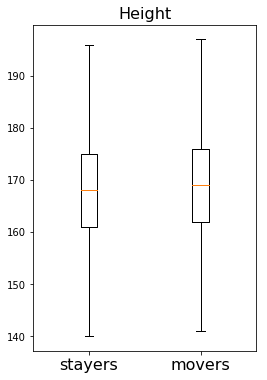

(168.03650380790725, 169.43488603900775, 0.832189553704994, 245673, 194628)

In [8]:
get_pheno_vector('Height', pheno_type, pheno_dfs, allStayers, allMovers)

### Comparing height in males vs. females

In [10]:
females = pheno_cat[pheno_cat.sex == 0].eid.tolist()
males = pheno_cat[pheno_cat.sex == 1].eid.tolist()

female_stayers = list(set(females) & set(allStayers))
female_movers = list(set(females) & set(allMovers))

male_stayers = list(set(males) & set(allStayers))
male_movers = list(set(males) & set(allMovers))

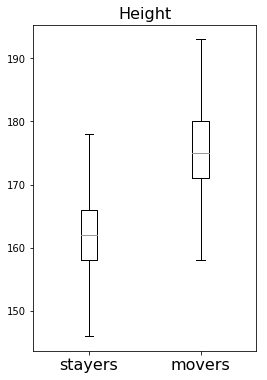

(161.94058281535095, 175.12487014701998, 8.141435026636966, 132083, 113590)

In [13]:
get_pheno_vector('Height', pheno_type, pheno_dfs, female_stayers, male_stayers)

## Comparing last generation stayers/movers

In [58]:
# load pickled data
with open('kinlists_190512.pic','rb') as f:
    parents_stayed, parents_moved, sib_parents_stayed, sib_parents_moved, cousins_in_clusters_stayers, outlier_cousins_stayers = pickle.load(f)

In [59]:
print(set(parents_stayed) & set(sib_parents_stayed))
print(set(parents_stayed) & set(outlier_cousins_stayers))
print(set(sib_parents_stayed) & set(outlier_cousins_stayers)) 

set()
set()
set()


In [60]:
groupedStayers = list(set(parents_stayed + sib_parents_stayed + cousins_in_clusters_stayers))  # 36739
#groupedStayers = parents_stayed + sib_parents_stayed # 34700`
print(len(groupedStayers))
groupedMovers = list(set(parents_moved + sib_parents_moved + outlier_cousins_stayers))  # 5919
#groupedMovers = parents_moved + sib_parents_moved # 5867
print(len(groupedMovers))

27636
1935


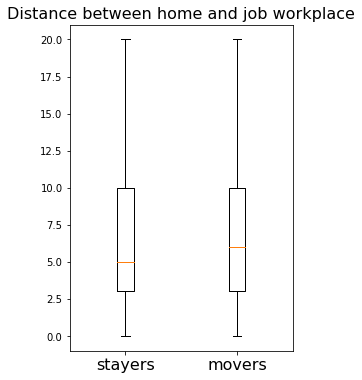

(10.846921458149481, 10.335864978902954, -4.711534800158079, 14731, 1185)

In [84]:
get_pheno_vector('Distance between home and job workplace', pheno_type, pheno_dfs, groupedStayers, groupedMovers)

### get and save summary data for all phenotypes

In [67]:
phenotypes_to_get = [x.rstrip() for x in open('../06_AC_phenotype_matrix_data/phenotypes_to_include_on_matrix.csv').readlines()]

# slist, mlist = groupedStayers, groupedMovers
# fname = 'lastGenData.npy'

slist, mlist = allStayers, allMovers
fname = 'allStayersAllMovers.npy'

collected_data = np.zeros([len(phenotypes_to_get),5])
for i,p in enumerate(phenotypes_to_get):
    ms, mm, pdiff, ns, nm = get_pheno_vector(p, pheno_type, pheno_dfs, slist, mlist, False)
    collected_data[i,:] = np.array([ms, mm, pdiff, ns, nm])   

# save vector ... eventually want to include as a column on the heatmap.
np.save('../06_AC_phenotype_matrix_data/' + fname, collected_data)

## Compare between more than two lists (containing pairs of stayers, movers)

In [80]:
# collect data for each eidGroup 
col = 'Distance between home and job workplace'
eidGroups = [parents_stayed, parents_moved, sib_parents_stayed, sib_parents_moved,
             cousins_in_clusters_stayers, outlier_cousins_stayers]
grouplabels = ['pc_stayed','pc_moved','sibp_stayed','sibp_moved',
               'cousins_clusters','cousins_outlier']

# Make dictionary: eid => phenotype of interest
dtype = pheno_type[col]
phenodf = pd.read_csv('../00_csv_files/pheno_' + dtype + '.csv')
phenotypes = dict(zip(phenodf.eid,phenodf[col]))

m_to_plot = []

# total number of categories
n = np.unique(phenodf[col])
n = n[~np.isnan(n)]
n = n[np.where(n>=0)]
numCats = len(n)
print(numCats)

# for each eidGroup
for g in eidGroups:
    # collect data in a column
    d = phenodf[phenodf['eid'].isin(g)][col].values
    # ... remove NaN
    d_with_data = d[~np.isnan(d)] 
    # ... remove negative numbers
    d_pos = d_with_data[np.where(d_with_data>=0)]
    
    print(len(d),len(d_with_data),len(d_pos))
    m_to_plot.append(d_pos)

308
2345 1888 1888
503 390 390
23233 11851 11851
1387 770 770
2058 992 992
45 25 25


numbers:	 682		169		6695		436		560		16


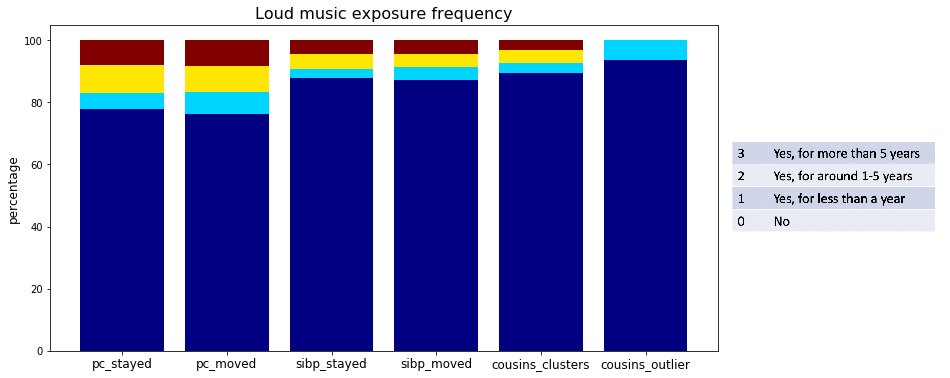

In [79]:
# PLOT: categorized or stratified data: stacked bars of percentages

f = plt.figure(figsize=(16,6))
gs = GridSpec(1, 20, figure=f)
ax = f.add_subplot(gs[:,:15])
ax2 = f.add_subplot(gs[:,15:])  

plotVals = []
cols = get_ncolors_from_cmap(numCats,colormap='jet')

table_for_stats = []

for i,m in enumerate(m_to_plot):
    labels, counts = np.unique(m, return_counts=True)
    percentages = [x/np.sum(counts)*100 for x in counts]
    table_for_stats.append(counts)
    bot = 0
    for j,p in enumerate(percentages):
        ax.bar(i+1, p , align='center', bottom=bot, color=cols[j])
        bot = bot + p

ax.set_ylabel('percentage',fontsize=12)
ax.set_xticks(np.arange(len(grouplabels))+1)
ax.set_xticklabels(grouplabels,fontsize=12)
ax.set_title(col,fontsize=16)

fname = col + '.png'
#fname = 'Leisure social activities.png'
img=mpimg.imread('../05_pheno_codes/' + fname)
ax2.imshow(img)
ax2.set_axis_off()

print('numbers:\t','\t\t'.join(str(y) for y in [len(x) for x in m_to_plot]))

plt.show()

numbers:  1888		390		11851		770		992		25
means:    13.34		10.07		10.26		10.22		13.17		17.96


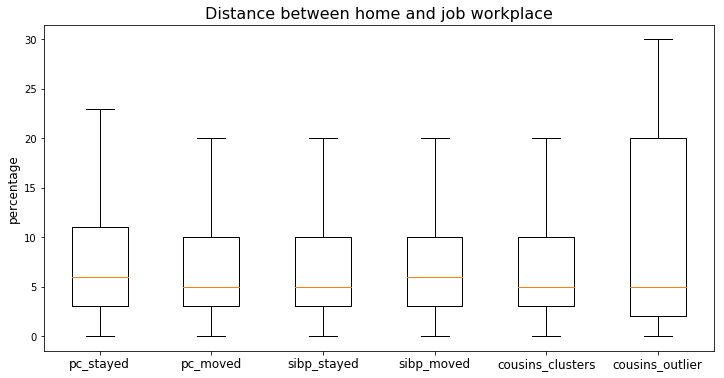

In [81]:
# PLOT: integer or continuous data:  boxplots (or violinplots)
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.boxplot(m_to_plot,showfliers=False)
#ax.boxplot(m_to_plot)
#ax.violinplot(m_to_plot)

ax.set_ylabel('percentage',fontsize=12)
ax.set_xticks(np.arange(len(grouplabels))+1)
ax.set_xticklabels(grouplabels,fontsize=12)
ax.set_title(col,fontsize=16)

print('numbers: ','\t\t'.join(str(y) for y in [len(x) for x in m_to_plot]))
print('means:   ','\t\t'.join(['{:01.2f}'.format(y) for y in [np.mean(x) for x in m_to_plot]]))

plt.show()

## Classifying last generation movers/stayers inferred from parent_child, sibs, cousins

In [19]:
# load stuff
# parent_child
kinship = pd.read_csv('../00_csv_files/kinship_data.csv')
kinship_1degree = kinship[kinship['Kinship'].between(0.17, 0.35)]
parent_child = kinship_1degree[kinship_1degree['IBS0'].between(0, 0.001)]

# cousins
cousins = pd.read_csv('../00_csv_files/reciprocal_clusters_3.csv')
# POB-POR distances
pob_por_migration = pd.read_csv('../00_csv_files/pob_por_migration.csv')

### Parent-oldest kid:
  * Start with parent_child = all pairs from kinship
  * reorder columns so that parents are first => save as .csv parent_child_pairs.csv
  * only keep the parent_oldest_child pairs => save as .csv parent_oldest_child_pairs.csv
  * Of these, find kids who DIDN’T move. 
  * Of these, divide into Parents Moved vs. Parents Stayed
  * Hypothesis parents-moved = better off

In [20]:
parent_child.head(3)

,uniqID,ID1,DOB_id1,ID2,DOB_id2,HetHet,IBS0,Kinship,POB_distance,POR_distance
346,rel26,1001138,1966,5723574,1940,0.067,0.0001,0.2465,0.000000,0.000000
377,rel49,1002195,1962,5556470,1937,0.066,0.0000,0.2465,9848.857802,54424.259297
398,rel65,1003047,1944,4606394,1963,0.065,0.0000,0.2461,0.000000,7071.067812


In [21]:
# re-order parent_child so that parents are first, children are second
# save in new df = parent_child_pairs
# save new df as parent_child_pairs.csv
# o = open('tmp.csv','w')
# cols = ['parent','DOB_parent','Child','DOB_child','HetHet','IBS0','Kinship','POB_distance','POR_distance']
# o.write(','.join(cols) + '\n')
# for i,row in parent_child.iterrows():
#     r = row.tolist()
#     if r[2] > r[4]:
#         dob1 = r[4]
#         id1 = r[3]
#         dob2 = r[2]
#         id2 = r[1]
#         r[1] = id1
#         r[2] = dob1
#         r[3] = id2
#         r[4] = dob2
#     o.write(','.join([str(x) for x in r[1:]]) + '\n')
# o.close()
# parent_child_pairs = pd.read_csv('tmp.csv')
# !rm tmp.csv
# parent_child_pairs.to_csv('../00_csv_files/parent_child_pairs.csv',index=False)
# parent_child_pairs.head(5)

In [5]:
# only keep the parent_oldest_child pairs => save as .csv parent_oldest_child_pairs.csv
# cols = parent_child_pairs.columns.tolist()
# info = {}
# o = open('tmp.csv','w')
# o.write(','.join(cols) + '\n')
# for i,row in parent_child_pairs.iterrows():
#     r = row.tolist()
#     if r[0] in info.keys():
#         if r[3] < info[r[0]][3]:
#             info[r[0]] = r
#     else:
#         info[r[0]] = r

# for parent in sorted(info.keys()):
#     o.write(','.join([str(x) for x in info[parent]]) + '\n')

# parent_oldest_child_pairs = pd.read_csv('tmp.csv')
# !rm tmp.csv
# parent_oldest_child_pairs.to_csv('../00_csv_files/parent_oldest_child_pairs.csv',index=False)
# o.close()
# print(len(parent_child_pairs),len(parent_oldest_child_pairs))
# parent_oldest_child_pairs.head(5)

In [6]:
# multiple_parents = parent_oldest_child_pairs[parent_oldest_child_pairs.duplicated(subset='Child',keep=False)].sort_values(by='Child')
# print(len(multiple_parents))
# multiple_parents.head(8)

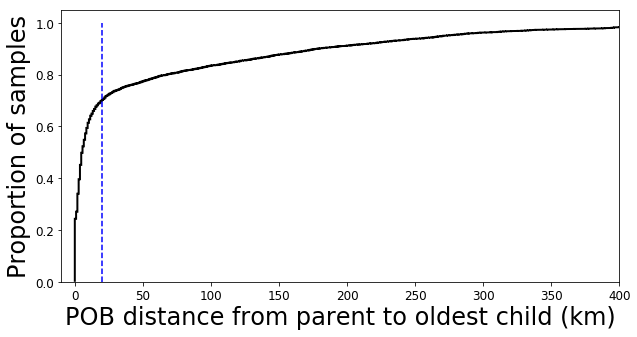

In [22]:
f,a = plt.subplots(1,1,figsize=(10,5))
parent_oldest_child_pairs = pd.read_csv('../00_csv_files/parent_oldest_child_pairs.csv')
a.hist(parent_oldest_child_pairs['POB_distance']/1000, 1000, density=True, histtype='step', cumulative=True, color='k', linewidth = 2)
a.set_xlim([-10,400])
a.set_xlabel('POB distance from parent to oldest child (km)',fontsize=24)
a.set_ylabel('Proportion of samples',fontsize=24)
a.tick_params(axis='both', which='major', labelsize=12)
a.plot([20,20],[0,1],'--b')
plt.show()

In [8]:
# what to do with children with more than one parent?
# if both parents moved: keep one parent
# if one parent moved, and one parent stayed: REMOVE from analysis
# if both parents stayed: keep one parent.

# pob_por_dist = dict(zip(pob_por_migration.eid,pob_por_migration.distances))

# children = multiple_parents.Child.tolist()
# parents = multiple_parents.parent.tolist()

# two_parents = {}

# moveThreshold = 20000 

# for i,c in enumerate(children):
#     p = parents[i]
#     sp = str(p).split('.')[0]
#     if pob_por_dist[p] > moveThreshold:
#         sp += '_m' # moved
#     else:
#         sp += '_s' # stayed
#     if c in two_parents.keys():
#         two_parents[c].append(sp)
#     else:
#         two_parents[c] = [sp]

# # make list of parents to remove
# # make two_parents dict: kid => [p1_m,p2_s] OR [p1_m,p2_m] OR [p1_s,p2_s]
# # through dictionary: 
# #    if value = [_m and _s] add both parents to remove list
# #    if vlaue = [_m and _m] add first parent to remove list

# def parse_parentType(s):
#     p,psm = s.split('_')
#     return int(p), psm

# parents_to_remove = []        
# for c in two_parents.keys():
#     parent1, parent1_stay_move = parse_parentType(two_parents[c][0])
#     parent2, parent2_stay_move = parse_parentType(two_parents[c][1])
#     if parent1_stay_move != parent2_stay_move:
#         parents_to_remove.extend([parent1,parent2])
#     else:
#         parents_to_remove.append(parent1)

# # make new df with removed parents dropped
# i_to_remove = parent_oldest_child_pairs[parent_oldest_child_pairs.parent.isin(parents_to_remove)].index.tolist()
# print(len(i_to_remove))

# parent_oldestChild_pairs_nr = parent_oldest_child_pairs.drop(index=i_to_remove)
# print(len(parent_oldest_child_pairs)-len(parent_oldestChild_pairs_nr))
# parent_oldestChild_pairs_nr.to_csv('../00_csv_files/parent_oldestChild_pairs_nr.csv',index=False)

In [23]:
# load dataframe where 1 parent, 1 oldest child
parent_oldestChild_pairs_nr = pd.read_csv('../00_csv_files/parent_oldestChild_pairs_nr.csv')
print(len(parent_oldestChild_pairs_nr))
parent_oldestChild_pairs_nr.head(5)

4236


,parent,DOB_parent,Child,DOB_child,HetHet,IBS0,Kinship,POB_distance,POR_distance
0,1003047.0,1944.0,4606394.0,1963.0,0.065,0.0000,0.2461,0.000000,7071.067812
1,1003050.0,1937.0,2464947.0,1968.0,0.065,0.0001,0.2459,283028.267140,82855.295546
2,1003827.0,1940.0,1243359.0,1963.0,0.066,0.0001,0.2473,8485.281374,1414.213562
3,1005248.0,1940.0,2256925.0,1965.0,0.067,0.0001,0.2468,21260.291625,1000.000000
4,1006118.0,1940.0,5346915.0,1966.0,0.068,0.0001,0.2483,23345.235060,7280.109889


In [24]:
# find the kids that didn't move POB-POR
moveThreshold = 20000
stayers = pob_por_migration[pob_por_migration.distances < moveThreshold].eid.tolist()
movers = pob_por_migration[pob_por_migration.distances >= moveThreshold].eid.tolist()
kids_that_stayed = parent_oldestChild_pairs_nr[parent_oldestChild_pairs_nr.Child.isin(stayers)]
print(len(kids_that_stayed))
kids_that_stayed.head(5)

2848


,parent,DOB_parent,Child,DOB_child,HetHet,IBS0,Kinship,POB_distance,POR_distance
0,1003047.0,1944.0,4606394.0,1963.0,0.065,0.0000,0.2461,0.000000,7071.067812
1,1003050.0,1937.0,2464947.0,1968.0,0.065,0.0001,0.2459,283028.267140,82855.295546
2,1003827.0,1940.0,1243359.0,1963.0,0.066,0.0001,0.2473,8485.281374,1414.213562
4,1006118.0,1940.0,5346915.0,1966.0,0.068,0.0001,0.2483,23345.235060,7280.109889
6,1006192.0,1938.0,2565124.0,1958.0,0.067,0.0000,0.2513,7000.000000,0.000000


In [25]:
# divide kids_that_stayed into parent_moved & parent_stayed (list of eids for kids)
moveThreshold = 20000
parents_moved = kids_that_stayed[kids_that_stayed.POB_distance >= moveThreshold].Child.tolist()
parents_stayed = kids_that_stayed[kids_that_stayed.POB_distance < moveThreshold].Child.tolist()
print('parents moved: ', len(parents_moved), ', parents_stayed: ',len(parents_stayed))

parents moved:  503 , parents_stayed:  2345


In [26]:
set(parents_moved) & set(parents_stayed)

set()

In [13]:
# To recap: I have kids that stayed (POB to POR)
# ... and divided them into two groups: those where the parents moved or stayed (POB to POR)
# now we can compare phenotypes! between the two groups. See bottom of this Notebook

### Sibs: 
  * Load from uniq_sib_clusters_190429.pic
  * find sibs where parents NOT in dataset
  * Divide into parents moved (sib POB > 20km) vs. parents didn’t move (sib POB < 20km)
  * Hypothesis: parents-moved = better off

In [27]:
with open('uniq_sib_clusters_190429.pic', 'rb') as f:
    sibs = pickle.load(f)
parent_child_pairs = pd.read_csv('../00_csv_files/parent_child_pairs.csv')
chidren_with_parents_set = set(parent_child_pairs.Child.tolist())

In [28]:
# go through sibs and remove groups where one or more member is in 'child' of parent_child_pairs
sibs_no_parents = []
for sgroup in sibs:
    sibset = set([int(x) for x in sgroup.split(',')])
    if len(sibset & chidren_with_parents_set) == 0:
        sibs_no_parents.append(sgroup)
print(len(sibs), len(sibs_no_parents))

18516 18330


In [30]:
# go through each sib group and determine if parents MOVED or not
# get POB each sib, get all pairwise distances
# add all distances ... mover if > moveThreshold
pobE = dict(zip(pob_por_migration.eid,pob_por_migration.POB_east))
pobN = dict(zip(pob_por_migration.eid,pob_por_migration.POB_north))

In [31]:
sib_parents_moved = []
sib_parents_stayed = []
moveThreshold = 20000
for sgroup in sibs_no_parents:
    s = [int(x) for x in sgroup.split(',')]
    totalDist = 0
    coords = [(pobE[eid],pobN[eid]) for eid in s if eid in pobE.keys()]
    for i, point in enumerate(coords[:-1]):
        totalDist += ukb.dist_between_points(point, coords[i+1])
    if totalDist > moveThreshold:
        sib_parents_moved.extend(s)
    else:
        sib_parents_stayed.extend(s)
print('parents moved: ', len(sib_parents_moved), ', parents_stayed: ',len(sib_parents_stayed))

parents moved:  5364 , parents_stayed:  32355


In [33]:
moveThreshold = 20000
pob_por_movers = pob_por_migration[pob_por_migration.distances > moveThreshold].eid.tolist()
pob_por_stayers = pob_por_migration[pob_por_migration.distances <= moveThreshold].eid.tolist()
sib_stayed_parents_stayed = list(set(sib_parents_stayed) & set(pob_por_stayers))
sib_stayed_parents_moved = list(set(sib_parents_moved) & set(pob_por_stayers))
sib_moved_parents_stayed = list(set(sib_parents_stayed) & set(pob_por_movers))
sib_moved_parents_moved = list(set(sib_parents_moved) & set(pob_por_movers))
print('parents moved: ', len(sib_stayed_parents_moved), ' stayers, ', len(sib_moved_parents_moved), ' movers.')
print('parents stayed: ', len(sib_stayed_parents_stayed), ' stayers, ', len(sib_moved_parents_stayed), ' movers.')

parents moved:  1387  stayers,  3976  movers.
parents stayed:  23233  stayers,  9084  movers.


In [34]:
# # filter each of these lists for folks who stayed?
# # doesn't really make sense. Drop off kid, kid stays, parent moves on?
# def filter_for_stayers(eids,pob_por_migration):
#     moveThreshold = 20000
#     filtered_list = []
#     pob_por_distances = dict(zip(pob_por_migration.eid,pob_por_migration.distances))
#     for eid in eids:
#         if eid in pob_por_distances.keys() and pob_por_distances[eid] < moveThreshold:
#             filtered_list.append(eid)
#     return filtered_list

# parents_stayed_sib_stayed = filter_for_stayers(parents_stayed,pob_por_migration)
# parents_moved_sib_stayed = filter_for_stayers(parents_moved,pob_por_migration)

# print('parents moved: ', len(parents_moved_sib_stayed), ', parents_stayed: ',len(parents_stayed_sib_stayed))

### Cousins:
  * Load from '../00_csv_files/reciprocal_clusters_3.csv'
  * Modify sliding window to get eids of points included and excluded
  * Clusters. Main group vs. outliers. Compare.
  * Predict outliers better off.

In [34]:
cousins = pd.read_csv('../00_csv_files/reciprocal_clusters_3.csv')
cousin_clusters = cousins.clusterID.tolist()
print(len(cousins))
print(cousin_clusters[:3])

3304
['1852688|3118085|5101958', '1888745|3337945|5561096', '1069187|1739011|4842664']


[1852688, 3118085, 5101958]


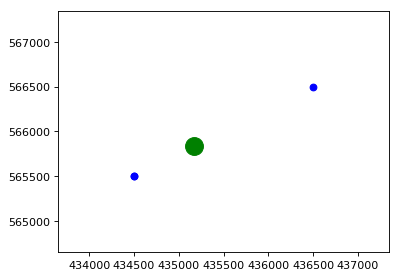

mean distance:  993.807989999918
points in cluster:  [1852688, 3118085, 5101958]
point[s] outside cluster:  []


In [35]:
# testing code . . . 
pobE = dict(zip(pob_por_migration.eid,pob_por_migration.POB_east))
pobN = dict(zip(pob_por_migration.eid,pob_por_migration.POB_north))

testList = [int(x) for x in cousin_clusters[0].split('|')]
print(testList)
d, ins, outs, jnk1, jnk2 = ukb.slidingWindowDisplacement(testList, pobE, pobN, 2, True)
print('mean distance: ', d)
print('points in cluster: ' , ins)
print('point[s] outside cluster: ' , outs)

In [36]:
# checking above
pob_por_migration[pob_por_migration.eid.isin(testList)]

,eid,POB_east,POB_north,POR_east,POR_north,distances,angles,POR_POB_popDensity
254801,1852688,436500,566500,437000.0,565000.0,1581.138830,161.565051,1.0
256156,3118085,434500,565500,430000.0,565000.0,4527.692569,263.659808,1.0
258231,5101958,434500,565500,430000.0,564000.0,4743.416490,251.565051,1.0


In [37]:
# what should the distance cutoff be for being outside a cluster? 
# see below = I'm choosing 12km (so max distance b/t two points ~ 24km)
distances_to_centroid = []

for cluster in cousin_clusters:
    eids = [int(x) for x in cluster.split('|')]
    d,i,o,j1,j2 = slidingWindowDisplacement(eids, pobE, pobN)
    distances_to_centroid.append(d)
    
distances_to_centroid = np.array(distances_to_centroid)

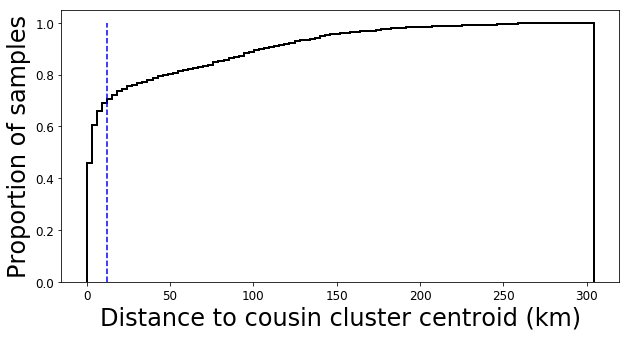

In [38]:
f,a = plt.subplots(1,1,figsize=(10,5))

#parent_oldest_child_pairs = pd.read_csv('../00_csv_files/parent_oldest_child_pairs.csv')
a.hist(distances_to_centroid/1000, 100, density=True, histtype='step', cumulative=True, color='k', linewidth = 2)
#a.set_xlim([-10,300])
a.set_xlabel('Distance to cousin cluster centroid (km)',fontsize=24)
a.set_ylabel('Proportion of samples',fontsize=24)
a.tick_params(axis='both', which='major', labelsize=12)
a.plot([12,12],[0,1],'--b')
plt.show()


In [39]:
# filter out any cousin clusters with parents in the dataset
cousins_no_parents = []
for cgroup in cousin_clusters:
    cousin_set = set([int(x) for x in cgroup.split('|')])
    if len(cousin_set & chidren_with_parents_set) == 0:
        cousins_no_parents.append(cgroup)
print(len(cousin_clusters), len(cousins_no_parents))

3304 3245


In [40]:
# collect eids in clusters and eids in outliers
cousins_in_clusters = []
outlier_cousins = []
distance_to_centroid_threshold = 12000

for cluster in cousins_no_parents:
    eids = [int(x) for x in cluster.split('|')]
    d,ins,outs,j1,j2 = slidingWindowDisplacement(eids, pobE, pobN)

    if d > distance_to_centroid_threshold:
        cousins_in_clusters.extend(ins)
        outlier_cousins.extend(outs)
    else:
        cousins_in_clusters.extend(ins)
        cousins_in_clusters.extend(outs)
    
print('Cousins in clusters: ', len(cousins_in_clusters))
print('Outlier cousins: ', len(outlier_cousins))

Cousins in clusters:  9432
Outlier cousins:  529


In [41]:
# filter these for stayers.
cousins_in_clusters_movers = list(set(cousins_in_clusters) & set(pob_por_movers))
cousins_in_clusters_stayers = list(set(cousins_in_clusters) & set(pob_por_stayers))
outlier_cousins_movers = list(set(outlier_cousins) & set(pob_por_movers))
outlier_cousins_stayers = list(set(outlier_cousins) & set(pob_por_stayers))
print('Cousins in clusters: ', len(cousins_in_clusters_stayers), ' stayers, ', len(cousins_in_clusters_movers), ' movers.')
print('Outlier cousins: ', len(outlier_cousins_stayers), ' stayers, ', len(outlier_cousins_movers), ' movers.')


Cousins in clusters:  5810  stayers,  1905  movers.
Outlier cousins:  146  stayers,  307  movers.


In [43]:
# check for overlap
movethreshold=20000
allStayers = pob_por_migration[pob_por_migration.distances<=movethreshold].eid.tolist()
allMovers =  pob_por_migration[pob_por_migration.distances> movethreshold].eid.tolist()
print(len(parents_stayed), len(set(parents_stayed) & set(allStayers))) # should be all of them
print(len(parents_moved), len(set(parents_moved) & set(allStayers))) # should be all of them
print(len(sib_stayed_parents_stayed), len(set(sib_stayed_parents_stayed) & set(allStayers))) # should be all of them
print(len(sib_stayed_parents_moved), len(set(sib_stayed_parents_moved) & set(allStayers))) # should be all of them
print(len(outlier_cousins_stayers), len(set(outlier_cousins_stayers) & set(allStayers))) # should be all of them
print(len(cousins_in_clusters_stayers), len(set(cousins_in_clusters_stayers) & set(allStayers))) # should be all of them
print(len(set(outlier_cousins_stayers) & set(sib_stayed_parents_stayed))) # oops there are 28
print(len(set(outlier_cousins_stayers) & set(sib_stayed_parents_moved))) # oops there is 5
print(len(set(outlier_cousins_stayers) & set(parents_stayed))) # ok 0
print(len(set(outlier_cousins_stayers) & set(parents_moved))) # ok 0
print(len(set(sib_stayed_parents_stayed) & set(parents_stayed))) # ok 0
print(len(set(sib_stayed_parents_moved) & set(parents_moved))) # ok 0

print(len(set(cousins_in_clusters_stayers) & set(sib_stayed_parents_stayed))) # oops there are 837
print(len(set(cousins_in_clusters_stayers) & set(sib_stayed_parents_moved))) # oops there is 36

2345 2345
503 503
23233 23233
1387 1387
146 146
5810 5810
28
5
0
0
0
0
837
36


In [44]:
removeUs = list(set(outlier_cousins_stayers) & set(sib_stayed_parents_stayed))
removeUs.extend(list(set(outlier_cousins_stayers) & set(sib_stayed_parents_moved)))
print(removeUs)
print(len(outlier_cousins_stayers))
os = list(set(outlier_cousins_stayers) - set(removeUs))
outlier_cousins_stayers = os

[3641088, 2654722, 4507139, 3275272, 2048652, 5884567, 4444568, 3999133, 1459620, 4711976, 1741487, 1008179, 3392565, 1907788, 2039373, 4189008, 4551505, 5615057, 5670616, 1146208, 6016993, 1524965, 1278058, 1176171, 3699308, 2542191, 5133941, 4373623, 3279653, 1394918, 2654803, 5281011, 5018873]
146


In [45]:
print(len(outlier_cousins_stayers))

113


In [46]:
removeUs = list(set(cousins_in_clusters_stayers) & set(sib_stayed_parents_stayed))
removeUs.extend(list(set(cousins_in_clusters_stayers) & set(sib_stayed_parents_moved)))
print(len(removeUs))
print(len(cousins_in_clusters_stayers))
ccs = list(set(cousins_in_clusters_stayers) - set(removeUs))
cousins_in_clusters_stayers = ccs

873
5810


In [47]:
print(len(cousins_in_clusters_stayers))

4937


In [57]:
# save lists of eids
eidGroups = [parents_stayed, parents_moved, sib_stayed_parents_stayed, sib_stayed_parents_moved,
             cousins_in_clusters_stayers, outlier_cousins_stayers]
with open('kinlists_190512.pic','wb') as o:
     pickle.dump(eidGroups, o)

## movers vs. stayers num kin

numbers:  88259 47321
means:  1.48 1.37


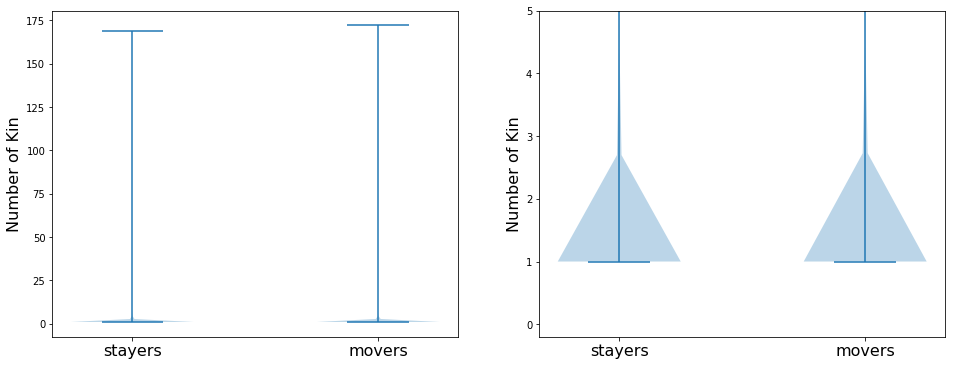

In [41]:
# from a kinship dataframe (or slice), make dictionary: kinDict[eid] = [list,of,kin]
kinship = pd.read_csv('../00_csv_files/kinship_data.csv')
kinDict = ukb.kindf_to_kindict(kinship)

move_kinnumber = [len(kinDict[x]) for x in movers if x in kinDict.keys()] 
stay_kinnumber = [len(kinDict[x]) for x in stayers if x in kinDict.keys()] 
m_to_plot = [stay_kinnumber,move_kinnumber]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
grouplabels = ['stayers','movers']
#ax.boxplot(m_to_plot)
#ax.boxplot(m_to_plot)
ax1.violinplot(m_to_plot)
ax1.set_xticks([1,2])
ax1.set_xticklabels(grouplabels,fontsize=16)
ax1.set_ylabel('Number of Kin',fontsize=16)
ax2.violinplot(m_to_plot)
ax2.set_xticks([1,2])
ax2.set_ylabel('Number of Kin',fontsize=16)
ax2.set_xticklabels(grouplabels,fontsize=16)
ax2.set_ylim([-0.2,5])
print('numbers: ',' '.join(str(y) for y in [len(x) for x in m_to_plot]))
print('means: ','{:01.2f}'.format(np.mean(stay_kinnumber)),'{:01.2f}'.format(np.mean(move_kinnumber)))
plt.show()

In [2]:
pob_por_ac = pd.read_csv('../00_csv_files/pob_por_ac_distances.csv')
pob_por_ac.head(2)

,eid,center,distances,POB_east,POB_north,POR_east,POR_north,POB_distance,POR_distance,closest_center_POR,POR_distance_closest,POB_distance_closest,closest_center_POB
0,1136349,11004,229901.065678,68500,801500,252000.0,663000.0,234227.018930,7490.487100,11004.0,7490.487100,234227.018930,11004
1,1071275,11004,196729.509734,66500,798500,211000.0,665000.0,234138.707601,48107.415198,11004.0,48107.415198,234138.707601,11004


In [8]:
mus_wba_eids = [int(m.split()[0]) for m in open('../00_csv_files/mus_wba_eids.csv','r').readlines()]
print(len(mus_wba_eids))
print(mus_wba_eids[0])

329746
4194304


In [10]:
ey = pd.read_csv('../pheno/pheno_eduYears.csv', delimiter = ' ')
eduYears = dict(zip(ey.eid,ey.Eduyears))
print(eduYears[4194304])

13


In [12]:
movers = [int(m.split()[0]) for m in open('../08_gwas/wba_movers.csv','r').readlines()]
stayers = [int(m.split()[0]) for m in open('../08_gwas/wba_stayers.csv','r').readlines()]
bornFar = [int(m.split()[0]) for m in open('../08_gwas/wba_bornFar.csv','r').readlines()]
bornClose = [int(m.split()[0]) for m in open('../08_gwas/wba_bornClose.csv','r').readlines()]

In [18]:
mover_eduyears = [eduYears[x] for x in movers if x in eduYears.keys()]
stayer_eduyears = [eduYears[x] for x in stayers if x in eduYears.keys()]
bornFar_eduyears = [eduYears[x] for x in bornFar if x in eduYears.keys()]
bornClose_eduyears = [eduYears[x] for x in bornClose if x in eduYears.keys()]

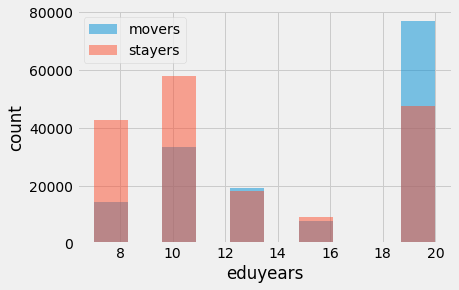

In [30]:
plt.hist(mover_eduyears, alpha = 0.5, label = 'movers')
plt.hist(stayer_eduyears, alpha = 0.5, label = 'stayers')
plt.style.use('fivethirtyeight')
plt.ylabel('count')
plt.xlabel('eduyears')
plt.legend()
plt.show()

In [39]:
print('mover variance:  ', '{:2.1f}'.format(np.var(mover_eduyears)))
print('stayer variance: ', '{:2.1f}'.format(np.var(stayer_eduyears)))
print('#movers: ',len(mover_eduyears))
print('#stayers: ',len(stayer_eduyears))

mover variance:   24.1
stayer variance:  23.9
#movers:  151390
#stayers:  175606
